In [2]:
'''
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group 
the passenger is travelling with and pp is their number within the group. People in a group are often family members, 
but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the 
voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P 
for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship 
Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are 
trying to predict.
'''

"\nPassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group \nthe passenger is travelling with and pp is their number within the group. People in a group are often family members, \nbut not always.\n\nHomePlanet - The planet the passenger departed from, typically their planet of permanent residence.\n\nCryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the \nvoyage. Passengers in cryosleep are confined to their cabins.\n\nCabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P \nfor Port or S for Starboard.\n\nDestination - The planet the passenger will be debarking to.\n\nAge - The age of the passenger.\n\nVIP - Whether the passenger has paid for special VIP service during the voyage.\n\nRoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship \nTitanic's many luxury amenit

In [3]:
# Import Dependencies for Download and Clean
# run in terminal to use bigquery  "pip install --upgrade google-cloud-bigquery"
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
'/Users/spicious/Desktop/News Datasets/Resources/spaceship-titanic-387720-729aac731f9f.json')

In [4]:
# Import Dependencies for Random Forest Model
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [5]:
# Import for Data Imputation
from scipy import stats
import numpy as np
from sklearn import impute

In [6]:
# Import Modules for K-Nearest Neighbors
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [7]:
project_id = 'spaceship-titanic-387720'
client = bigquery.Client(credentials= credentials,project=project_id)

In [8]:
query_Amenities = client.query("""
   SELECT *
   FROM Starship_Titanic.Amenities""")

query_PassengerInfo = client.query("""
   SELECT *
   FROM Starship_Titanic.PassengerInfo""")

query_PlanetInfo = client.query("""
   SELECT *
   FROM Starship_Titanic.Planet""")

results_Amenities = query_Amenities.result()
results_PassengerInfo = query_PassengerInfo.result()
results_PlanetInfo = query_PlanetInfo.result()

Amenities_df = pd.DataFrame(results_Amenities)
PassengerInfo_df = pd.DataFrame(results_PassengerInfo)
PlanetInfo_df = pd.DataFrame(results_PlanetInfo)

In [9]:
print(Amenities_df.loc[0][0])
print(PassengerInfo_df.loc[0][0])
print(PlanetInfo_df.loc[0][0])

Row(('4446_05', 'B/175/S', False, 0.0, 4017.0, None, None, 2260.0), {'PassengerId': 0, 'Cabin': 1, 'VIP': 2, 'RoomService': 3, 'FoodCourt': 4, 'ShoppingMall': 5, 'Spa': 6, 'VRDeck': 7})
Row(('6512_02', 'Photons Drivery', None, 'A/80/S', None, True), {'PassengerId': 0, 'Name': 1, 'HomePlanet': 2, 'Cabin': 3, 'Age': 4, 'Transported': 5})
Row(('3896_01', None, '55 Cancri e', None), {'PassengerId': 0, 'HomePlanet': 1, 'Destination': 2, 'CryoSleep': 3})


In [10]:
Amenities_sorted = pd.DataFrame()
i = 0
while i < 8:
    Amenities_sorted[i] = Amenities_df[0].apply(lambda x: x[i])
    i += 1

Amenities_sorted = Amenities_sorted.rename(columns={0: "PassengerId", 
                   1: "Cabin", 
                   2: "VIP", 
                   3: "RoomService",
                   4: "FoodCourt",
                   5: "ShoppingMall",
                   6: "Spa",
                   7: "VRDeck"})

In [11]:
Amenities_sorted

,PassengerId,Cabin,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,4446_05,B/175/S,False,0.0,4017.0,NaN,NaN,2260.0
1,8906_01,F/1723/S,False,720.0,2.0,NaN,NaN,0.0
2,2122_01,E/154/S,False,0.0,618.0,NaN,NaN,0.0
3,3008_01,D/92/P,False,0.0,0.0,NaN,NaN,0.0
4,0008_02,B/1/P,False,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...
12965,2289_01,F/465/P,False,20.0,0.0,2559.0,20.0,0.0
12966,3567_01,F/739/P,False,0.0,0.0,2687.0,35.0,340.0
12967,4012_01,B/153/S,False,0.0,7000.0,8251.0,1523.0,0.0
12968,7941_01,C/257/P,False,0.0,116.0,10705.0,9181.0,10.0


In [12]:
PassengerInfo_sorted = pd.DataFrame()
i = 0
while i < 6:
    PassengerInfo_sorted[i] = PassengerInfo_df[0].apply(lambda x: x[i])
    i += 1
    
PassengerInfo_sorted = PassengerInfo_sorted.rename(columns={0: "PassengerId", 
                   1: "Name", 
                   2: "HomePlanet", 
                   3: "Cabin",
                   4: "Age",
                   5: "Transported"})

In [13]:
PassengerInfo_sorted

,PassengerId,Name,HomePlanet,Cabin,Age,Transported
0,6512_02,Photons Drivery,None,A/80/S,NaN,True
1,8202_03,Charga Unkcatted,None,C/306/S,NaN,True
2,1050_01,Evendy Buchansen,None,G/157/P,NaN,None
3,6081_01,Ecco Shpie,None,F/1256/P,NaN,None
4,6550_01,Grumak Porkilte,None,B/252/S,NaN,None
...,...,...,...,...,...,...
12965,0818_01,Ksorab Couseced,Europa,B/29/S,71.0,True
12966,1502_04,Hadaton Donotaked,Europa,C/54/P,71.0,None
12967,1131_01,Mizark Comessic,Europa,B/44/S,75.0,None
12968,0378_03,Naslon Pirejus,Europa,B/11/S,79.0,False


In [14]:
PlanetInfo_sorted = pd.DataFrame()
i = 0
while i < 4:
    PlanetInfo_sorted[i] = PlanetInfo_df[0].apply(lambda x: x[i])
    i += 1
    
PlanetInfo_sorted = PlanetInfo_sorted.rename(columns={0: "PassengerId", 
                   1: "HomePlanet", 
                   2: "Destination", 
                   3: "CryoSleep"})

In [15]:
PlanetInfo_sorted

,PassengerId,HomePlanet,Destination,CryoSleep
0,3896_01,None,55 Cancri e,None
1,7711_01,None,TRAPPIST-1e,None
2,4420_01,None,TRAPPIST-1e,None
3,4984_02,None,PSO J318.5-22,None
4,8435_01,None,TRAPPIST-1e,None
...,...,...,...,...
12965,9166_01,Europa,55 Cancri e,True
12966,9177_01,Europa,55 Cancri e,True
12967,9177_02,Europa,55 Cancri e,True
12968,9215_01,Europa,TRAPPIST-1e,True


In [16]:
# Merging tables
merge_df = pd.merge(Amenities_sorted, PassengerInfo_sorted, on = 'PassengerId', how = 'inner')
df = pd.merge(merge_df, PlanetInfo_sorted, on = 'PassengerId', how = 'inner')

In [17]:
# Cleaning up Column Duplications
df = df.drop(['Cabin_y', 'HomePlanet_y'], axis=1)

In [18]:
# Renaming Columns
df = df.rename(columns={'Cabin_x': "Cabin", 
                   'HomePlanet_x': "HomePlanet"})

In [19]:
df["Transported"].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [20]:
# Drop all rows with missing null's in the training data column
df.dropna(subset = ['Transported'], inplace=True)

In [21]:
#check dataframe
print(df.shape)
df.head(5)

(8693, 14)


,PassengerId,Cabin,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,HomePlanet,Age,Transported,Destination,CryoSleep
0,4446_05,B/175/S,False,0.0,4017.0,NaN,NaN,2260.0,Phah Chocaters,Europa,33.0,True,TRAPPIST-1e,None
1,8906_01,F/1723/S,False,720.0,2.0,NaN,NaN,0.0,Rena Gainney,Earth,19.0,False,55 Cancri e,False
4,0008_02,B/1/P,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,Europa,34.0,True,TRAPPIST-1e,True
5,0014_01,F/3/P,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,Mars,27.0,False,55 Cancri e,False
6,0020_03,E/0/S,False,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,Earth,29.0,False,55 Cancri e,True


In [22]:
# Check columns
columns = list(df.columns)
columns

['PassengerId',
 'Cabin',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'HomePlanet',
 'Age',
 'Transported',
 'Destination',
 'CryoSleep']

In [23]:
df.isnull().sum()

PassengerId       0
Cabin           199
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
HomePlanet      201
Age             179
Transported       0
Destination     182
CryoSleep       217
dtype: int64

# Data Munging

In [24]:
# Make plans
'''
1) Check for missing values in all columns
1.5) Consider Imputation
2) remove unnecessary columns such as PassengerId and Name
3) Convert categorical variables into indicator variables for HomePlanet, CryoSleep, Deck, Side, Destination, VIP, Transported
4) Split up Cabin column into three different features
'''

'\n1) Check for missing values in all columns\n1.5) Consider Imputation\n2) remove unnecessary columns such as PassengerId and Name\n3) Convert categorical variables into indicator variables for HomePlanet, CryoSleep, Deck, Side, Destination, VIP, Transported\n4) Split up Cabin column into three different features\n'

In [26]:
# Split Cabin column in three different Columns
df[['Deck','RoomNum','Side']] = df.Cabin.str.split("/", expand = True)
del df['Cabin']

AttributeError: 'DataFrame' object has no attribute 'Cabin'

In [28]:
# Reorder dataset to make me happy
df = df[['PassengerId',
 'Name',
 'HomePlanet',
 'CryoSleep',
 'Deck',
 'RoomNum',
 'Side',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported']]

# Check to see everything is going to plan
print(df.head())

  PassengerId                Name HomePlanet CryoSleep Deck RoomNum Side  \
0     4446_05      Phah Chocaters     Europa      None    B     175    S   
1     8906_01        Rena Gainney      Earth     False    F    1723    S   
4     0008_02      Altardr Flatic     Europa      True    B       1    P   
5     0014_01         Flats Eccle       Mars     False    F       3    P   
6     0020_03  Mollen Mcfaddennon      Earth      True    E       0    S   

   Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall  Spa  \
0  TRAPPIST-1e  33.0  False          0.0     4017.0           NaN  NaN   
1  55 Cancri e  19.0  False        720.0        2.0           NaN  NaN   
4  TRAPPIST-1e  34.0  False          0.0        0.0           NaN  0.0   
5  55 Cancri e  27.0  False       1286.0      122.0           NaN  0.0   
6  55 Cancri e  29.0  False          0.0        0.0           NaN  0.0   

   VRDeck Transported  
0  2260.0        True  
1     0.0       False  
4     0.0        True  
5 

In [24]:
# Drop unnecessary columns
del df['PassengerId']
del df['Name']

In [25]:
# Check drops
columns = list(df.columns)
columns

['HomePlanet',
 'CryoSleep',
 'Deck',
 'RoomNum',
 'Side',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Transported']

In [26]:
# examining missing values
print("Missing values distribution: ")
print(df.isnull().mean())

Missing values distribution: 
HomePlanet      0.023122
CryoSleep       0.024963
Deck            0.022892
RoomNum         0.022892
Side            0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Transported     0.000000
dtype: float64


In [27]:
# check datatype in each column
print("Column datatypes: ")
print(df.dtypes)

Column datatypes: 
HomePlanet       object
CryoSleep        object
Deck             object
RoomNum          object
Side             object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported      object
dtype: object


In [28]:
#df2['Transported'] = df2['Transported'].map({'True': True, 'False': False}) 
df['Transported'] = df['Transported'].astype(dtype = 'bool', errors = 'ignore')

In [29]:
# Exploring the data
print('HomePlanet', df["HomePlanet"].unique())
print('CryoSleep', df["CryoSleep"].unique())
print('Deck', df["Deck"].unique())
print('Side', df["Side"].unique())
print('Destination', df["Destination"].unique())
print('VIP', df["VIP"].unique())
print('Transported', df["Transported"].unique())

HomePlanet ['Europa' 'Earth' 'Mars' None]
CryoSleep [None False True]
Deck ['B' 'F' 'E' 'C' 'G' 'D' None 'A' 'T']
Side ['S' 'P' None]
Destination ['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' None]
VIP [False True None]
Transported [ True False]


In [30]:
df.isnull().sum()

HomePlanet      201
CryoSleep       217
Deck            199
RoomNum         199
Side            199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [31]:
df.shape

(8693, 14)

In [32]:
df["Transported"].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

# Nan Values

In [33]:
df_clean = df.dropna()
df_clean

,HomePlanet,CryoSleep,Deck,RoomNum,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
495,Europa,False,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
497,Europa,True,B,1,P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True
498,Earth,False,F,4,P,55 Cancri e,24.0,False,0.0,1.0,0.0,0.0,637.0,False
499,Mars,True,F,5,P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0,True
500,Earth,False,G,0,P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12964,Europa,False,E,315,P,TRAPPIST-1e,32.0,False,8151.0,2052.0,1919.0,7352.0,754.0,False
12965,Mars,False,F,465,P,TRAPPIST-1e,37.0,False,20.0,0.0,2559.0,20.0,0.0,True
12966,Earth,False,F,739,P,TRAPPIST-1e,20.0,False,0.0,0.0,2687.0,35.0,340.0,False
12968,Europa,False,C,257,P,TRAPPIST-1e,41.0,False,0.0,116.0,10705.0,9181.0,10.0,False


In [34]:
compression_opts = dict(method='zip',
                        archive_name='titanic.csv')  
df.to_csv('titanic.zip', index=False,
          compression=compression_opts)  

# Random Forest Model

In [35]:
# Define features set
X = df_clean.copy()
X.drop("Transported", axis=1, inplace=True)
X.head()

,HomePlanet,CryoSleep,Deck,RoomNum,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
495,Europa,False,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
497,Europa,True,B,1,P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0
498,Earth,False,F,4,P,55 Cancri e,24.0,False,0.0,1.0,0.0,0.0,637.0
499,Mars,True,F,5,P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0
500,Earth,False,G,0,P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0


In [36]:
# Define target vector
y = df_clean["Transported"].values.reshape(-1, 1)
y[:5]

array([[False],
       [ True],
       [False],
       [ True],
       [ True]])

In [37]:
# Dummy Categorical Variables
X = pd.get_dummies(X)

In [38]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [39]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [40]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [41]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [42]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [43]:
# Fit the model and use .ravel()on the "y_train" data. 
rf_model = rf_model.fit(X_train, y_train)

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [44]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test)

In [45]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [46]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,705,137
Actual 1,177,672


Accuracy Score : 0.8143110585452396
Classification Report
              precision    recall  f1-score   support

       False       0.80      0.84      0.82       842
        True       0.83      0.79      0.81       849

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.82      0.81      0.81      1691



In [47]:
# Get the feature importance array
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:100]

[(0.07447629146927538, 'Spa'),
 (0.07038660233216101, 'Age'),
 (0.06627293229783245, 'VRDeck'),
 (0.060892135966090576, 'RoomService'),
 (0.05977782598370213, 'CryoSleep_False'),
 (0.0593638955790175, 'FoodCourt'),
 (0.05354727770774385, 'ShoppingMall'),
 (0.045041322255381204, 'CryoSleep_True'),
 (0.01615520770857291, 'HomePlanet_Earth'),
 (0.014692994883978534, 'HomePlanet_Europa'),
 (0.0113692009082334, 'Deck_F'),
 (0.010792861543748868, 'Deck_E'),
 (0.009609066587193762, 'HomePlanet_Mars'),
 (0.009291254255882486, 'Deck_G'),
 (0.008925864084896505, 'Destination_TRAPPIST-1e'),
 (0.008747141443948593, 'Side_S'),
 (0.008394352650640834, 'Destination_55 Cancri e'),
 (0.007896829754068423, 'Side_P'),
 (0.0060339625016005505, 'Deck_B'),
 (0.005696585020079958, 'Deck_C'),
 (0.004452545596153306, 'Destination_PSO J318.5-22'),
 (0.0031387608270332097, 'Deck_D'),
 (0.0018817413995296873, 'Deck_A'),
 (0.0018027751762501503, 'VIP_False'),
 (0.001687493209203072, 'VIP_True'),
 (0.00162536957757

# K-Nearest Neighbors

In [48]:
 # Split target column from dataset
y = df_clean['Transported']
X = df_clean.drop(columns='Transported')

In [49]:
# Preview the data
X[:5]

,HomePlanet,CryoSleep,Deck,RoomNum,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
495,Europa,False,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
497,Europa,True,B,1,P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0
498,Earth,False,F,4,P,55 Cancri e,24.0,False,0.0,1.0,0.0,0.0,637.0
499,Mars,True,F,5,P,TRAPPIST-1e,45.0,False,0.0,0.0,0.0,0.0,0.0
500,Earth,False,G,0,P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0


In [50]:
# Print first five entries for target
y[:5]

495    False
497     True
498    False
499     True
500     True
Name: Transported, dtype: bool

In [51]:
# Encode the categorical variables using get_dummies
X = pd.get_dummies(X)

In [52]:
# Preview the data
X.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,RoomNum_997,RoomNum_998,RoomNum_999,Side_P,Side_S,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
495,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,1,...,0,0,0,1,0,0,0,1,1,0
497,14.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,...,0,0,0,1,0,1,0,0,1,0
498,24.0,0.0,1.0,0.0,0.0,637.0,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0
499,45.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,0
500,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,...,0,0,0,1,0,0,0,1,1,0


In [53]:
 # Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [54]:
# Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [57]:
#Implementation of KNN

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [58]:
# use cross_val_score function
# create empty list to store neighbors
# create empty list to store scores

from sklearn.model_selection import cross_val_score

neighbors = []
cv_scores = []

# Perform 10-fold cross validation with K=5 for KNN 
# Range of K we want to try
# k = 5 for KNeighborsClassifier

for k in range(1, 101, 2):
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(
    knn, X_train, y_train, cv = 10, scoring = 'accuracy')
    cv_scores.append(scores.mean())
    
    # Passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
    # cv=10 for 10 folds
    # Scoring='accuracy' for evaluation metric
    
scores = cross_val_score(knn, X, y, cv=10, scoring = 'accuracy')
print(scores)


[0.63072378 0.64844904 0.7282127  0.92319055 0.90828402 0.93047337
 0.9112426  0.64792899 0.70118343 0.6908284 ]


The optimal score of K neighbors = 15 


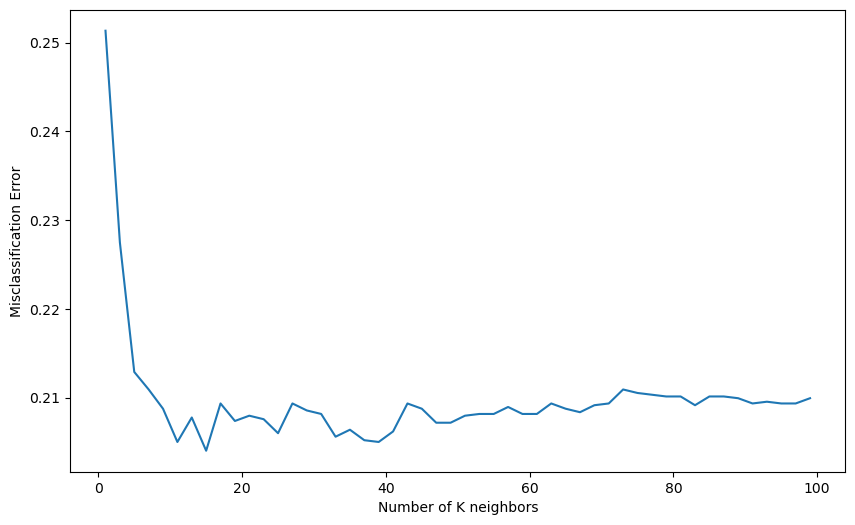

In [59]:
# Misclassification error versus k
MSE = [1-x for x in cv_scores]

# Determining the best k value
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal score of K neighbors = %d " %optimal_k)

# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt 

# Plot misclassification error versus k
plt.figure(figsize = (10,6))
plt.plot(neighbors, MSE)
plt.xlabel("Number of K neighbors")
plt.ylabel("Misclassification Error")
plt.show()

In [60]:
# Instantiate the model
model = KNeighborsClassifier(n_neighbors=43)

In [61]:
# Instantiate the model
model = KNeighborsClassifier(n_neighbors=43)

In [62]:
# Train the model 
model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=43)

In [63]:
# Create predictions
y_pred = model.predict(X_test_scaled)

# Review the predictions
y_pred

array([ True, False,  True, ...,  True,  True,  True])

In [64]:
# Print confusion matrix
confusion_matrix(y_pred,y_test)

array([[305, 105],
       [530, 751]])

In [65]:
# Print classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       False       0.37      0.74      0.49       410
        True       0.88      0.59      0.70      1281

    accuracy                           0.62      1691
   macro avg       0.62      0.67      0.60      1691
weighted avg       0.75      0.62      0.65      1691



# Logistic Regression Model

In [40]:
# Load the data into a Pandas DataFrame
df_space_titanic_data = pd.read_csv(
    "Resources/titanic.csv")

# Display sample data
df_space_titanic_data.head(10)

,HomePlanet,CryoSleep,Deck,RoomNum,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True
5,Earth,False,F,0,P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True
6,Earth,False,F,2,S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True
7,Earth,False,F,3,S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True
8,Europa,True,B,1,P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True
9,Europa,False,B,1,P,55 Cancri e,45.0,False,39.0,7295.0,589.0,110.0,124.0,True


In [41]:
#Create dummy variables for columns with no numerical data
df_space_titanic_data_dummied = pd.get_dummies(df_space_titanic_data, columns = ['HomePlanet','CryoSleep','Deck', 'Side','Destination','VIP','Transported'])

In [42]:
# Display data with dummy variables
df_space_titanic_data_dummied.head(5)

,RoomNum,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_T,Side_P,Side_S,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Transported_False,Transported_True
0,0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,1,1,0,1,0
1,0,24.0,109.0,9.0,25.0,549.0,44.0,1,0,0,...,0,0,1,0,0,1,1,0,0,1
2,0,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0,...,0,0,1,0,0,1,0,1,1,0
3,0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,...,0,0,1,0,0,1,1,0,1,0
4,1,16.0,303.0,70.0,151.0,565.0,2.0,1,0,0,...,0,0,1,0,0,1,1,0,0,1


In [43]:
#Check the correlation between the "Transported True" and other variables
columns = list(df_space_titanic_data_dummied.columns)
for column in columns:
    print(f'The correlation between Transported True and {column} is:')
    print(df_space_titanic_data_dummied[column].corr(df_space_titanic_data_dummied['Transported_True']))

The correlation between Transported True and RoomNum is:
-0.044709212512367244
The correlation between Transported True and Age is:
-0.08053495096289977
The correlation between Transported True and RoomService is:
-0.24780057518573248
The correlation between Transported True and FoodCourt is:
0.05384967787072665
The correlation between Transported True and ShoppingMall is:
0.014997503550402407
The correlation between Transported True and Spa is:
-0.22013437204337394
The correlation between Transported True and VRDeck is:
-0.20776051156225803
The correlation between Transported True and HomePlanet_Earth is:
-0.168071206035927
The correlation between Transported True and HomePlanet_Europa is:
0.18072517280471817
The correlation between Transported True and HomePlanet_Mars is:
0.012837752706128257
The correlation between Transported True and CryoSleep_False is:
-0.46147983713876467
The correlation between Transported True and CryoSleep_True is:
0.4614798371387646
The correlation between T

---

In [44]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data 
#  Prepare the data. Use the StandardScaler module and fit_transform function to 
# scale all columns with numerical values
df_space_titanic_data_dummied_scaled = StandardScaler().fit_transform(df_space_titanic_data_dummied)
# Diplay the first five rows of the scaled data
df_space_titanic_data_dummied_scaled[0:5]




array([[-1.16728319,  0.69536494, -0.34631583, -0.28610256, -0.2829153 ,
        -0.27557718, -0.27028985, -1.08458249,  1.71850043, -0.51019054,
         0.73680609, -0.73680609, -0.18031672,  3.0906734 , -0.31170723,
        -0.24431496, -0.33975779, -0.69615777, -0.65230401, -0.02106469,
         1.01279624, -1.01279624, -0.52052932, -0.32327521,  0.66684463,
         0.15763402, -0.15763402,  1.00563385, -1.00563385],
       [-1.16728319, -0.33708928, -0.17810814, -0.28073519, -0.24372942,
         0.20646467, -0.23124164,  0.92201378, -0.58190268, -0.51019054,
         0.73680609, -0.73680609, -0.18031672, -0.32355408, -0.31170723,
        -0.24431496, -0.33975779,  1.43645599, -0.65230401, -0.02106469,
        -0.98736544,  0.98736544, -0.52052932, -0.32327521,  0.66684463,
         0.15763402, -0.15763402, -0.99439772,  0.99439772],
       [-1.16728319,  2.0031403 , -0.27995867,  1.84653335, -0.2829153 ,
         5.62043557, -0.22680435, -1.08458249,  1.71850043, -0.51019054,
  

In [45]:
# Create a DataFrame with the scaled data
df_space_titanic_data_scaled = pd.DataFrame(
    df_space_titanic_data_dummied_scaled,
    columns=['RoomNum','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','HomePlanet_Earth','HomePlanet_Europa','HomePlanet_Mars','CryoSleep_False','CryoSleep_True','Deck_A','Deck_B','Deck_C','Deck_D','Deck_E','Deck_F','Deck_G','Deck_T','Side_P','Side_S','Destination_55 Cancri e','Destination_PSO J318.5-22','Destination_TRAPPIST-1e','VIP_False','VIP_True','Transported_False','Transported_True'])

# Display sample data
df_space_titanic_data_scaled.head()

,RoomNum,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_T,Side_P,Side_S,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,Transported_False,Transported_True
0,-1.167283,0.695365,-0.346316,-0.286103,-0.282915,-0.275577,-0.270290,-1.084582,1.718500,-0.510191,...,-0.021065,1.012796,-1.012796,-0.520529,-0.323275,0.666845,0.157634,-0.157634,1.005634,-1.005634
1,-1.167283,-0.337089,-0.178108,-0.280735,-0.243729,0.206465,-0.231242,0.922014,-0.581903,-0.510191,...,-0.021065,-0.987365,0.987365,-0.520529,-0.323275,0.666845,0.157634,-0.157634,-0.994398,0.994398
2,-1.167283,2.003140,-0.279959,1.846533,-0.282915,5.620436,-0.226804,-1.084582,1.718500,-0.510191,...,-0.021065,-0.987365,0.987365,-0.520529,-0.323275,0.666845,-6.343808,6.343808,1.005634,-1.005634
3,-1.167283,0.282383,-0.346316,0.479046,0.298603,2.647405,-0.099010,-1.084582,1.718500,-0.510191,...,-0.021065,-0.987365,0.987365,-0.520529,-0.323275,0.666845,0.157634,-0.157634,1.005634,-1.005634
4,-1.165332,-0.887732,0.121271,-0.244356,-0.046233,0.220513,-0.268515,0.922014,-0.581903,-0.510191,...,-0.021065,-0.987365,0.987365,-0.520529,-0.323275,0.666845,0.157634,-0.157634,-0.994398,0.994398


---

In [46]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = df_space_titanic_data_scaled["Transported_True"]

# Separate the X variable, the features
X = df_space_titanic_data_scaled.drop(columns=["CryoSleep_False","Side_S","VIP_False","Transported_True","Transported_False"])

In [47]:
# Review the y variable Series
display(y.head())

0   -1.005634
1    0.994398
2   -1.005634
3   -1.005634
4    0.994398
Name: Transported_True, dtype: float64

In [48]:
# Review the X variable DataFrame
display(X.head())

,RoomNum,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True
0,-1.167283,0.695365,-0.346316,-0.286103,-0.282915,-0.275577,-0.270290,-1.084582,1.718500,-0.510191,...,-0.244315,-0.339758,-0.696158,-0.652304,-0.021065,1.012796,-0.520529,-0.323275,0.666845,-0.157634
1,-1.167283,-0.337089,-0.178108,-0.280735,-0.243729,0.206465,-0.231242,0.922014,-0.581903,-0.510191,...,-0.244315,-0.339758,1.436456,-0.652304,-0.021065,-0.987365,-0.520529,-0.323275,0.666845,-0.157634
2,-1.167283,2.003140,-0.279959,1.846533,-0.282915,5.620436,-0.226804,-1.084582,1.718500,-0.510191,...,-0.244315,-0.339758,-0.696158,-0.652304,-0.021065,-0.987365,-0.520529,-0.323275,0.666845,6.343808
3,-1.167283,0.282383,-0.346316,0.479046,0.298603,2.647405,-0.099010,-1.084582,1.718500,-0.510191,...,-0.244315,-0.339758,-0.696158,-0.652304,-0.021065,-0.987365,-0.520529,-0.323275,0.666845,-0.157634
4,-1.165332,-0.887732,0.121271,-0.244356,-0.046233,0.220513,-0.268515,0.922014,-0.581903,-0.510191,...,-0.244315,-0.339758,1.436456,-0.652304,-0.021065,-0.987365,-0.520529,-0.323275,0.666845,-0.157634


In [49]:
balance = y.value_counts()
balance

 0.994398    3401
-1.005634    3363
Name: Transported_True, dtype: int64

In [50]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [51]:
# Import the LogisticRegression module from SKLearn
#from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y_train)

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 0 to the model
logistic_regression_model = LogisticRegression(solver='liblinear', random_state=0)

# Fit the model using training data
lr_model = logistic_regression_model.fit(X_train, y_transformed)



In [52]:
y_pred = lr_model.predict(X_test)


In [53]:
y_pred

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [54]:
#convert y values to categorical values
y_test_transformed = lab.fit_transform(y_test)

In [55]:
# Print the balanced_accuracy score of the model

from sklearn.metrics import accuracy_score
# Display the accuracy score for the test dataset.
accuracy_score(y_test_transformed, y_pred)

0.7912477823772915

In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_transformed, y_pred)
print(confusion_matrix)

[[654 185]
 [168 684]]


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test_transformed, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       839
           1       0.79      0.80      0.79       852

    accuracy                           0.79      1691
   macro avg       0.79      0.79      0.79      1691
weighted avg       0.79      0.79      0.79      1691



# Trying Data Imputation

In [66]:
# Impute int values with mean.

titanic_df_impute = df.copy()

mean_imputer = impute.SimpleImputer(strategy='mean')

titanic_df_impute['Age'] = mean_imputer.fit_transform(titanic_df_impute['Age'].values.reshape(-1,1))
titanic_df_impute['RoomService'] = mean_imputer.fit_transform(titanic_df_impute['RoomService'].values.reshape(-1,1))
titanic_df_impute['FoodCourt'] = mean_imputer.fit_transform(titanic_df_impute['FoodCourt'].values.reshape(-1,1))
titanic_df_impute['ShoppingMall'] = mean_imputer.fit_transform(titanic_df_impute['ShoppingMall'].values.reshape(-1,1))
titanic_df_impute['Spa'] = mean_imputer.fit_transform(titanic_df_impute['Spa'].values.reshape(-1,1))
titanic_df_impute['VRDeck'] = mean_imputer.fit_transform(titanic_df_impute['VRDeck'].values.reshape(-1,1))

In [67]:
# Check to see if Mean Imputation was performed
titanic_df_impute.isnull().sum()

HomePlanet      201
CryoSleep       217
Deck            199
RoomNum         199
Side            199
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [68]:
## Use ffil and fillna to fill object values with the value nearest to it
titanic_df_impute['RoomNum'] = titanic_df_impute['RoomNum'].fillna(method='ffill')
titanic_df_impute['HomePlanet'] = titanic_df_impute['HomePlanet'].fillna(method='ffill')
titanic_df_impute['CryoSleep'] = titanic_df_impute['CryoSleep'].fillna(method='ffill')
titanic_df_impute['Deck'] = titanic_df_impute['Deck'].fillna(method='ffill')
titanic_df_impute['Side'] = titanic_df_impute['Side'].fillna(method='ffill')
titanic_df_impute['VIP'] = titanic_df_impute['VIP'].fillna(method='ffill')
titanic_df_impute['Destination'] = titanic_df_impute['Destination'].fillna(method='ffill')

In [71]:
# Check to see if categorical Imputation was performed
titanic_df_impute.isnull().sum()

HomePlanet      0
CryoSleep       1
Deck            0
RoomNum         0
Side            0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [70]:
titanic_df_impute

,HomePlanet,CryoSleep,Deck,RoomNum,Side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,None,B,175,S,TRAPPIST-1e,33.0,False,0.0,4017.0,173.729169,311.138778,2260.0,True
1,Earth,False,F,1723,S,55 Cancri e,19.0,False,720.0,2.0,173.729169,311.138778,0.0,False
4,Europa,True,B,1,P,TRAPPIST-1e,34.0,False,0.0,0.0,173.729169,0.000000,0.0,True
5,Mars,False,F,3,P,55 Cancri e,27.0,False,1286.0,122.0,173.729169,0.000000,0.0,False
6,Earth,True,E,0,S,55 Cancri e,29.0,False,0.0,0.0,173.729169,0.000000,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12964,Europa,False,E,315,P,TRAPPIST-1e,32.0,False,8151.0,2052.0,1919.000000,7352.000000,754.0,False
12965,Mars,False,F,465,P,TRAPPIST-1e,37.0,False,20.0,0.0,2559.000000,20.000000,0.0,True
12966,Earth,False,F,739,P,TRAPPIST-1e,20.0,False,0.0,0.0,2687.000000,35.000000,340.0,False
12968,Europa,False,C,257,P,TRAPPIST-1e,41.0,False,0.0,116.0,10705.000000,9181.000000,10.0,False
